# Das Multi-Layered Perceptron (MLP)

Wir haben nun alle Zutaten zusammen, um ein eigenes MLP zu programmieren. Dies sind:

* der __Perzeptron-Algorithmus__ zur Berechnung eines Ergebnisvektors aus einem Eingabevektor, der die Wahrscheinlichkeiten angibt, dass die Eingaben zu eine bestimmten Klasse gehören
* der __Backpropagation-Algorithmus__ zur Bestimmung der Gewichte aus Trainingsdaten. Diese Gewichte gehören zu einem Minimum der __Kostenfunktion__.

Bevor wir mit der Entwicklung beginnen, besorgen wir uns geeignete Testdaten.

## Die Testdaten

Zum Testen unserer Entwicklung verwenden wir wieder die Daten aus unserem ersten Beispiel: die handgeschriebenen Ziffern aus den Testdaten von `Scikit-learn`:

In [12]:
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()
X, y, images = digits.data, digits.target, digits.images

Anzahl Datensätze : 1797


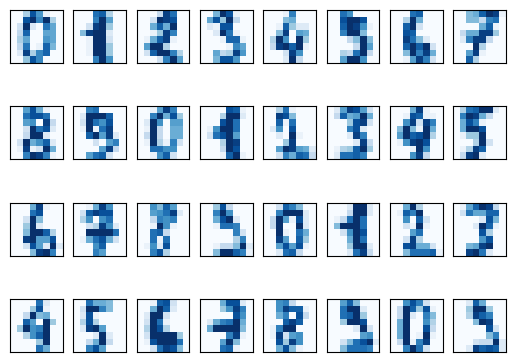

In [13]:
from dl1 import gallery

print(f"Anzahl Datensätze : {len(X)}")
rows, cols = 4, 8
gallery(images,rows, cols,cmap='Blues')


### Skalierung und Zerlegung der Datensätze in Trainings- und Testdaten

Die Bilddaten sind __X__ bestehen aus numerischen eindimensionalen Listen mit jeweils 8 x 8 = 64 Grauwerten zwischen 0 und 255. 

Wir brauchen für unsere Rechnungen Werte zwischen 0 und 1. Wir skalieren die Werte auf den Bereich zwischen 0 und 1:

In [14]:
X = X / 255.

Jetzt teilen wir die Daten in einen größeren Teil für das Training und einen kleineren Teil für die Tests auf:

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,random_state=42)

## Das MLP

Wir schreiben zunächst einmal den Code für ein Neuronales Netz auf, dass noch keine Trainingsfunktion besitzt. Die Gewichte werden zufällig erzeugt; ansonsten ist bereits die komplette Funktionalität vorhanden, d.h. aus einem Eingabevektor wird ein Ausgabevektor erzeugt, dessen größter Wert die Ziffer bestimmt. Das ist unsere Funktion __predict__. 

Außerdem implementieren wir eine Funktion __score__, die bei Eingabe eines Satzes von Testdaten den Anteil der richtigen Treffer berechnet. Das ganze Objekt nennen wir einfach ein "__ProtoMLP__".

Wir fügen bereits jetzt in der `init`-Methode ein Array namens `targets` hinzu. Wir werden diese später in der Traings-Routine verwenden. Sie enthält für jeden Index $k$ einen Vektor, der die Form (0,..., 0, 1, 0,..., 0), mit einer 1 an der $k$. Stelle hat. 

In [16]:
import numpy as np

class ProtoMLP:
    def __init__(self, n_input, n_hidden, n_output):

        self.wih = 2 * np.random.rand(n_hidden, n_input)  - 1
        self.who = 2 * np.random.rand(n_output, n_hidden) - 1

        self.transfer = lambda x: 1 / (1 + np.exp(-x))
        self.targets = [np.array([int(a == b) for a in range(n_output)], ndmin = 2) for b in range(n_output)]

    def predict(self, x):
        return np.argmax(self.forward(x.T)[0])

    def forward(self, x):
        #x = np.array(x, ndmin = 2).T

        hidden_input = np.dot(self.wih, x)
        hidden_output = self.transfer(hidden_input)

        final_input = np.dot(self.who, hidden_output)
        final_output = self.transfer(final_input)

        return final_output, hidden_output

    def score(self, test_x, test_y):
        falsch = []
        for n, (x, y) in enumerate(zip(test_x, test_y)):
            p = self.predict(x)
            if p != y:
                falsch.append(n)
        result = 1. - (len(falsch) / len(test_x))

        return result, falsch


### Aufbau des Netzwerks

Ein- und Ausgabeschicht sind durch das Problem definiert:

* 8 x 8 = 64 Neuronen in der __Eingabeschicht__
* 10 Neuronen in der __Ausgabeschicht__, eines für jede Ziffer von 0 bis 9

Bei der verborgenen Schicht sind wir frei, und hier beginnt die Arbeit des Data Scientists. Es gibt viele Möglichkeiten zum Experimentieren. Wir setzen die Anzahl der Neuronen auf 24, was einen guten Mittelwert ergibt.

* 24 Neuronen in der __verborgenen Schicht__

Wir erwarten, dass das "ProtoMLP" eine Trefferquote von etwa 10 % erzielt, was einem zufälligen Raten entspricht. Es ist eben noch kein _Wissen_ vorhanden. Probieren wir es aus, indem wir der`score`-Funktion die Testdaten übergeben:

In [17]:
p_mlp = ProtoMLP(8 * 8, 24, 10) 

score, _ = p_mlp.score(X_test,y_test)
print(f'Trefferquote: {score:.2%}')

Trefferquote: 9.26%


## Das lernende MLP

Jetzt fehlt uns zu unserem MLP nur noch die Funktion `fit`, die die Gewichte basierend auf den Trainingsdaten anpasst. Wir müssen dazu aus den vorgegebenen Werten für __y__, die die Ziffern 0 - 9 bestimmen, entsprechende 10-dimensionale Vektoren verwenden, die am Index y eine 1 und ansonsten eine 0 haben. Das sind genau die Tagert-Vektoren, die wir im `ProtoMLP` bereits definiert haben.

In [18]:
#from tqdm import tqdm

class MLP(ProtoMLP):
    
    def fit(self, train_x, train_y, lr = 0.1, epochs = 1):
        #for e in  tqdm(range(epochs)):
        for e in range(epochs):            
            for x, y in zip(train_x, train_y):
                self.backpropagation(x, self.targets[y], lr)

    def backpropagation(self, x, target, lr: float = 0.1):
        x = np.transpose(np.array(x, ndmin = 2))
        t = np.transpose(np.array(target, ndmin = 2))

        final_output, hidden_output = self.forward(x)
        output_error = t - final_output
        hidden_error = np.dot(self.who.T, output_error)

        self.who += lr * np.dot((output_error * final_output * (1.0 - final_output)), np.transpose(hidden_output))
        self.wih += lr * np.dot((hidden_error * hidden_output * (1.0 - hidden_output)), np.transpose(x))            


## Training und Test des MLP

Wir initialisieren das MLP wie zuvor mit den Anzahl der Neuronen der drei Schichten. Wir passen danach die Gewichte mit `fit` an und übergeben dabei die Trainings-Daten. Für den `score` verwenden wir die Test-Daten:

In [19]:
mlp = MLP(8 * 8, 24, 10) 

mlp.fit(X_train, y_train, epochs = 100)

In [20]:
score, falsch = mlp.score(X_test,y_test)
print(f'Trefferquote: {score:.2%}')

Trefferquote: 95.74%


Das sieht schon besser aus...

### Bewertung des Ergebnisses

In der Regel liegt die Trefferquote des trainierten MLP bei __90 %__! Allerdings haben wir auch 100 Durchläufe verwendet.

Dieses Ergebnis ist wirklich verblüffend und beeindruckend, wenn man den geringen Aufwand bei der Erstellung des "Programms" (die Trainingsfunktion hat weniger als 10 Zeilen) und die kurze Zeitspanne des Trainings bedenkt - nur wenige Sekunden.

Wie sehen die falsche bewerteten Ziffern aus? Die Indizes dieser Ziffern in den testdaten finden wir im array `falsch`:

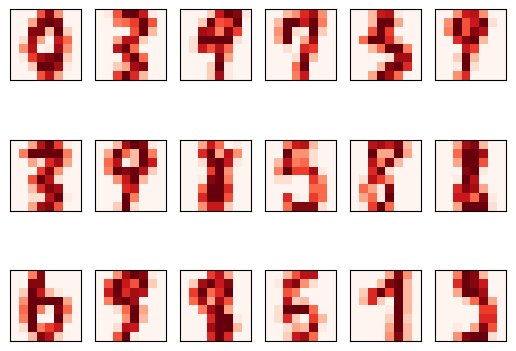

In [23]:
f_img = [X_test[k].reshape(8,8) for k in falsch]

rows, cols = 3, 6
gallery(f_img,rows, cols,cmap='Reds')

## Wie falsch sind die falschen Ergebnisse?

Mit Hilfe eines Balkendiagramms lassen sich die Werte an den zehn Output-Neuronen gut darstellen. Die Funktion `predict` wählt das Neuron mit dem größten Wert (= Wahrscheinlichkeit = Ähnlichkeit) aus. Sieht man sich einige Wert an, so erkennt man, dass die Entscheidung bei den falschen Werten meist recht knapp ausgefallen ist:

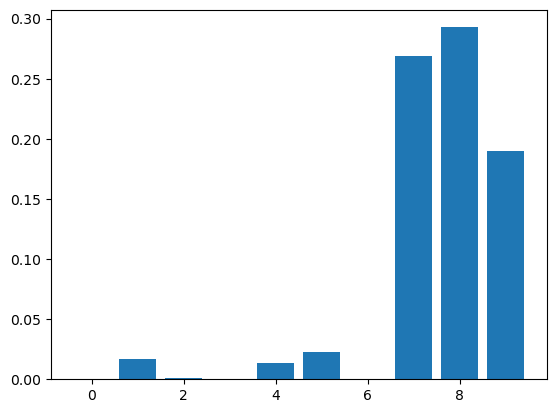

In [24]:
import matplotlib.pyplot as plt

X_falsch = X_test[falsch]
res = mlp.forward(X_falsch[7])[0]
plt.bar(list(range(10)),res);